In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction

from src.ml.loso import run_same_side_classifications, run_different_classifications

# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# Data Preparation

## Cognitive Load Info

In [2]:
path_to_experiment_info: str = "../data.nosync/usilaughs/all_experimento_info.csv"
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=1)

## Physiological Data

In [3]:
eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/67 [00:00<?, ?it/s]

528

In [4]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())

In [5]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [6]:
segment_size_in_secs = 4
eda_sample_rate = 4

segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate
experiment_info_as_dict = experiment_info.to_dict()

In [7]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info_as_dict,
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

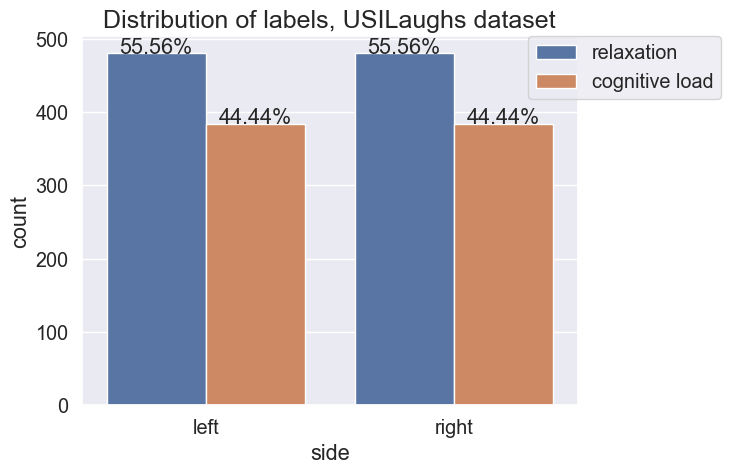

In [8]:
counts = get_labels_counts(labels_left, labels_right, ['relaxation', 'cognitive load'])
plot_binary_labels(
    counts=counts,
    title="Distribution of labels, USILaughs dataset",
    dataset_name="usilaughs",
    output_folder="../visualizations/"
)


The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [9]:
features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)


Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Coul

In [10]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)


# Machine Learning

## 5-fold CV (one seed)

In [33]:
model_selected: str = "RandomForestClassifier"
metrics_selected: str = "Accuracy"

#### LX v LX

In [12]:
averaged_results_cv_lxlx, all_results_cv_lxlx = run_cross_validation_prediction(
    x=features_left,
    y=labels_left,
    groups=groups_left,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=1,
    n_seeds_to_test_folds=1,
)


100%|██████████| 29/29 [00:00<00:00, 42.26it/s]


In [14]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.7643            0.7642  0.7642   0.7635   
ExtraTreesClassifier            0.7630            0.7629  0.7629   0.7623   
LGBMClassifier                  0.7526            0.7525  0.7525   0.7514   
XGBClassifier                   0.7396            0.7395  0.7395   0.7387   
BaggingClassifier               0.7291            0.7290  0.7290   0.7284   
LabelPropagation                0.7266            0.7265  0.7265   0.7257   
LabelSpreading                  0.7227            0.7226  0.7226   0.7216   
DecisionTreeClassifier          0.7187            0.7187  0.7187   0.7186   
KNeighborsClassifier            0.7175            0.7174  0.7174   0.7170   
AdaBoostClassifier              0.7123            0.7122  0.7122   0.7113   
NuSVC                           0.7122            0.7122  0.7122   0.7111   
SVC                             0.6979            0.6979  0.6979   0.6972   
ExtraTreeClassifier             0.6809            0.6810  0.6810   0.6803   
LogisticRegression              0.6445            0.6445  0.6445   0.6444   
CalibratedClassifierCV          0.6354            0.6354  0.6354   0.6353   
LinearSVC                       0.6354            0.6354  0.6354   0.6353   
RidgeClassifierCV               0.6354            0.6354  0.6354   0.6353   
RidgeClassifier                 0.6328            0.6327  0.6327   0.6326   
NearestCentroid                 0.6262            0.6262  0.6262   0.6260   
LinearDiscriminantAnalysis      0.6237            0.6236  0.6236   0.6234   
BernoulliNB                     0.6211            0.6211  0.6211   0.6201   
SGDClassifier                   0.6014            0.6016  0.6016   0.5982   
QuadraticDiscriminantAnalysis   0.5611            0.5613  0.5613   0.5056   
Perceptron                      0.5597            0.5601  0.5601   0.5399   
GaussianNB                      0.5482            0.5482  0.5482   0.4697   
PassiveAggressiveClassifier     0.5052            0.5057  0.5057   0.4661   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1059         0.0071            0.0071   
ExtraTreesClassifier              0.0721         0.0158            0.0159   
LGBMClassifier                    0.0330         0.0086            0.0086   
XGBClassifier                     0.0718         0.0157            0.0157   
BaggingClassifier                 0.0255         0.0140            0.0140   
LabelPropagation                  0.0074         0.0101            0.0101   
LabelSpreading                    0.0091         0.0101            0.0101   
DecisionTreeClassifier            0.0062         0.0125            0.0125   
KNeighborsClassifier              0.0056         0.0176            0.0176   
AdaBoostClassifier                0.0524         0.0200            0.0199   
NuSVC                             0.0164         0.0088            0.0088   
SVC                               0.0126         0.0123            0.0123   
ExtraTreeClassifier               0.0039         0.0170            0.0170   
LogisticRegression                0.0067         0.0087            0.0087   
CalibratedClassifierCV            0.1081         0.0113            0.0113   
LinearSVC                         0.0293         0.0102            0.0102   
RidgeClassifierCV                 0.0042         0.0125            0.0125   
RidgeClassifier                   0.0041         0.0128            0.0128   
NearestCentroid                   0.0347         0.0122            0.0122   
LinearDiscriminantAnalysis

#### RX vs RX

In [15]:
averaged_results_cv_rxrx, all_results_cv_rxrx = run_cross_validation_prediction(
    x=features_right,
    y=labels_right,
    groups=groups_right,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=1,
    n_seeds_to_test_folds=1,
)

100%|██████████| 29/29 [00:00<00:00, 45.66it/s]


In [16]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.8151            0.8152  0.8152   0.8149   
BaggingClassifier               0.8099            0.8100  0.8100   0.8097   
RandomForestClassifier          0.8086            0.8087  0.8087   0.8084   
KNeighborsClassifier            0.7995            0.7995  0.7995   0.7994   
LGBMClassifier                  0.7995            0.7996  0.7996   0.7991   
XGBClassifier                   0.7956            0.7957  0.7957   0.7955   
AdaBoostClassifier              0.7761            0.7760  0.7760   0.7758   
NuSVC                           0.7748            0.7748  0.7748   0.7746   
SVC                             0.7735            0.7735  0.7735   0.7733   
DecisionTreeClassifier          0.7631            0.7632  0.7632   0.7626   
LabelSpreading                  0.7579            0.7579  0.7579   0.7572   
ExtraTreeClassifier             0.7566            0.7566  0.7566   0.7562   
LabelPropagation                0.7566            0.7566  0.7566   0.7559   
CalibratedClassifierCV          0.7057            0.7056  0.7056   0.7053   
NearestCentroid                 0.7044            0.7044  0.7044   0.7041   
BernoulliNB                     0.7018            0.7017  0.7017   0.7014   
LinearSVC                       0.6979            0.6979  0.6979   0.6975   
GaussianNB                      0.6979            0.6977  0.6977   0.6962   
LinearDiscriminantAnalysis      0.6966            0.6965  0.6965   0.6962   
LogisticRegression              0.6940            0.6940  0.6940   0.6936   
RidgeClassifier                 0.6914            0.6913  0.6913   0.6909   
RidgeClassifierCV               0.6901            0.6900  0.6900   0.6895   
QuadraticDiscriminantAnalysis   0.6510            0.6511  0.6511   0.6441   
Perceptron                      0.6392            0.6399  0.6399   0.6230   
SGDClassifier                   0.6381            0.6378  0.6378   0.6301   
PassiveAggressiveClassifier     0.5353            0.5352  0.5352   0.5219   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0687         0.0055            0.0055   
BaggingClassifier                 0.0248         0.0093            0.0093   
RandomForestClassifier            0.1050         0.0050            0.0049   
KNeighborsClassifier              0.0054         0.0090            0.0090   
LGBMClassifier                    0.0340         0.0107            0.0107   
XGBClassifier                     0.0678         0.0092            0.0092   
AdaBoostClassifier                0.0539         0.0062            0.0062   
NuSVC                             0.0126         0.0096            0.0096   
SVC                               0.0108         0.0085            0.0085   
DecisionTreeClassifier            0.0063         0.0217            0.0217   
LabelSpreading                    0.0093         0.0193            0.0192   
ExtraTreeClassifier               0.0038         0.0201            0.0201   
LabelPropagation                  0.0072         0.0186            0.0186   
CalibratedClassifierCV            0.1107         0.0137            0.0136   
NearestCentroid                   0.0129         0.0141            0.0140   
BernoulliNB                       0.0037         0.0119            0.0118   
LinearSVC                         0.0292         0.0111            0.0111   
GaussianNB                        0.0036         0.0167            0.0167   
LinearDiscriminantAnalysis        0.0042         0.0131            0.0131   
LogisticRegression        

#### Visualizing differences

In [17]:
selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_cv_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_cv_lxlx
    for single_result in seed_res
]

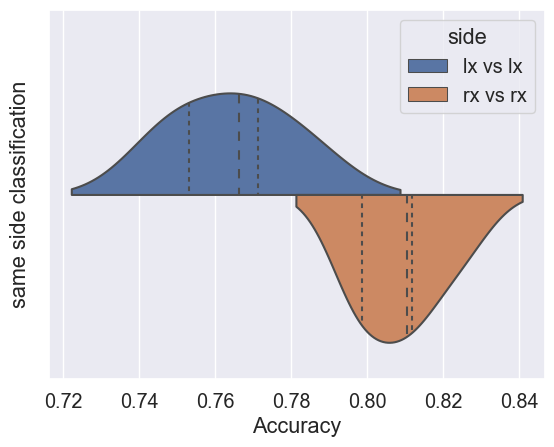

In [18]:
from seaborn import violinplot

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile')
# ax.set_ylim(0.5, 1.0)

#### LX vs RX

In [19]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
models_lxrx, _ = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)

100%|██████████| 29/29 [00:01<00:00, 20.20it/s]


In [17]:
models_lxrx.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.77,0.77,0.77,0.77,0.12
SVC,0.76,0.76,0.76,0.76,0.03
KNeighborsClassifier,0.76,0.76,0.76,0.75,0.01
ExtraTreesClassifier,0.75,0.75,0.75,0.75,0.08
AdaBoostClassifier,0.74,0.74,0.74,0.74,0.06
LGBMClassifier,0.73,0.73,0.73,0.73,0.38
LabelSpreading,0.73,0.73,0.73,0.73,0.02
NuSVC,0.73,0.73,0.73,0.73,0.03
LabelPropagation,0.73,0.73,0.73,0.73,0.02


#### RX vs LX

In [18]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
models_rxrx, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)

100%|██████████| 29/29 [00:01<00:00, 27.39it/s]


In [19]:
models_rxrx.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.71,0.71,0.71,0.71,0.01
RandomForestClassifier,0.71,0.71,0.71,0.71,0.12
BaggingClassifier,0.71,0.71,0.71,0.71,0.03
LabelPropagation,0.71,0.71,0.71,0.71,0.03
LabelSpreading,0.71,0.71,0.71,0.71,0.02
ExtraTreesClassifier,0.70,0.70,0.70,0.70,0.08
LGBMClassifier,0.70,0.70,0.70,0.70,0.38
XGBClassifier,0.70,0.70,0.70,0.70,0.05
NuSVC,0.70,0.70,0.70,0.70,0.02


## 5-fold CV - different seeds

### LX vs LX

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [34]:
averaged_results_cv_multi_lxlx, all_results_cv_multi_lxlx = run_cross_validation_prediction(
    x=features_left,
    y=labels_left,
    groups=groups_left,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=10,
    n_seeds_to_test_folds=10,
)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.81it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.86it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.50it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 21.95it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.06it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.13it/s]

100%|██████████| 29/29 [00:01<00:00, 23.03it/s]

100%|██████████| 29/29 [00:01<00:00, 22.82it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.80it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.76it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.96it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.88it/s]


In [35]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_multi_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.6217            0.6217  0.6217   0.6213   
RandomForestClassifier          0.6121            0.6121  0.6121   0.6116   
KNeighborsClassifier            0.6102            0.6102  0.6102   0.6097   
NuSVC                           0.6038            0.6038  0.6038   0.6033   
LabelSpreading                  0.6036            0.6036  0.6036   0.6029   
LabelPropagation                0.6034            0.6034  0.6034   0.6027   
BaggingClassifier               0.6005            0.6005  0.6005   0.5987   
LGBMClassifier                  0.5986            0.5986  0.5986   0.5981   
XGBClassifier                   0.5922            0.5922  0.5922   0.5916   
ExtraTreeClassifier             0.5867            0.5867  0.5867   0.5863   
AdaBoostClassifier              0.5734            0.5734  0.5734   0.5728   
DecisionTreeClassifier          0.5720            0.5720  0.5720   0.5717   
SVC                             0.5615            0.5615  0.5615   0.5606   
BernoulliNB                     0.5516            0.5516  0.5516   0.5510   
NearestCentroid                 0.5482            0.5482  0.5482   0.5475   
RidgeClassifierCV               0.5389            0.5389  0.5389   0.5379   
LogisticRegression              0.5379            0.5379  0.5379   0.5368   
LinearSVC                       0.5371            0.5371  0.5371   0.5360   
RidgeClassifier                 0.5369            0.5369  0.5369   0.5357   
LinearDiscriminantAnalysis      0.5355            0.5355  0.5355   0.5344   
GaussianNB                      0.5308            0.5308  0.5308   0.5123   
CalibratedClassifierCV          0.5227            0.5227  0.5227   0.5196   
QuadraticDiscriminantAnalysis   0.5188            0.5188  0.5188   0.4989   
PassiveAggressiveClassifier     0.5110            0.5110  0.5110   0.4832   
SGDClassifier                   0.5073            0.5073  0.5073   0.4881   
Perceptron                      0.5010            0.5010  0.5010   0.4871   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.1220         0.0012            0.0012   
RandomForestClassifier            0.2047         0.0011            0.0011   
KNeighborsClassifier              0.0097         0.0011            0.0011   
NuSVC                             0.0743         0.0013            0.0013   
LabelSpreading                    0.0372         0.0012            0.0012   
LabelPropagation                  0.0227         0.0012            0.0012   
BaggingClassifier                 0.0573         0.0012            0.0012   
LGBMClassifier                    0.0598         0.0009            0.0009   
XGBClassifier                     0.1635         0.0011            0.0011   
ExtraTreeClassifier               0.0047         0.0012            0.0012   
AdaBoostClassifier                0.0855         0.0011            0.0011   
DecisionTreeClassifier            0.0118         0.0012            0.0012   
SVC                               0.0523         0.0011            0.0011   
BernoulliNB                       0.0045         0.0014            0.0014   
NearestCentroid                   0.0048         0.0017            0.0017   
RidgeClassifierCV                 0.0049         0.0016            0.0016   
LogisticRegression                0.0063         0.0016            0.0016   
LinearSVC                         0.0605         0.0015            0.0015   
RidgeClassifier                   0.0047         0.0016            0.0016   
LinearDiscriminantAnalysis

### RX vs RX

In [36]:
averaged_results_cv_multi_rxrx, all_results_cv_multi_rxrx = run_cross_validation_prediction(
    x=features_right,
    y=labels_right,
    groups=groups_right,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=10,
    n_seeds_to_test_folds=10,
)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.64it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.50it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.64it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.46it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.62it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.24it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.55it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.57it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.50it/s]

100%|██████████| 29/29 [00:01<00:00, 23.50it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.29it/s]


In [37]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_multi_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.6519            0.6519  0.6519   0.6514   
RandomForestClassifier          0.6518            0.6518  0.6518   0.6513   
BaggingClassifier               0.6436            0.6436  0.6436   0.6418   
LGBMClassifier                  0.6415            0.6415  0.6415   0.6411   
XGBClassifier                   0.6409            0.6409  0.6409   0.6406   
LabelSpreading                  0.6384            0.6384  0.6384   0.6380   
LabelPropagation                0.6382            0.6382  0.6382   0.6378   
AdaBoostClassifier              0.6339            0.6339  0.6339   0.6336   
KNeighborsClassifier            0.6249            0.6249  0.6249   0.6246   
DecisionTreeClassifier          0.6237            0.6237  0.6237   0.6233   
NuSVC                           0.6229            0.6229  0.6229   0.6225   
ExtraTreeClassifier             0.6093            0.6093  0.6093   0.6089   
SVC                             0.6090            0.6090  0.6090   0.6086   
NearestCentroid                 0.5908            0.5908  0.5908   0.5904   
BernoulliNB                     0.5888            0.5888  0.5888   0.5884   
RidgeClassifier                 0.5854            0.5854  0.5854   0.5849   
LogisticRegression              0.5851            0.5851  0.5851   0.5846   
CalibratedClassifierCV          0.5850            0.5850  0.5850   0.5841   
LinearSVC                       0.5842            0.5842  0.5842   0.5837   
LinearDiscriminantAnalysis      0.5838            0.5838  0.5838   0.5833   
RidgeClassifierCV               0.5837            0.5837  0.5837   0.5832   
GaussianNB                      0.5768            0.5768  0.5768   0.5708   
QuadraticDiscriminantAnalysis   0.5585            0.5585  0.5585   0.5461   
SGDClassifier                   0.5235            0.5235  0.5235   0.5085   
PassiveAggressiveClassifier     0.5217            0.5217  0.5217   0.4995   
Perceptron                      0.5087            0.5087  0.5087   0.4969   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.1170         0.0012            0.0012   
RandomForestClassifier            0.2006         0.0011            0.0011   
BaggingClassifier                 0.0568         0.0012            0.0012   
LGBMClassifier                    0.0611         0.0011            0.0011   
XGBClassifier                     0.1619         0.0012            0.0012   
LabelSpreading                    0.0373         0.0013            0.0013   
LabelPropagation                  0.0229         0.0013            0.0013   
AdaBoostClassifier                0.0855         0.0012            0.0012   
KNeighborsClassifier              0.0097         0.0013            0.0013   
DecisionTreeClassifier            0.0116         0.0012            0.0012   
NuSVC                             0.0571         0.0013            0.0013   
ExtraTreeClassifier               0.0047         0.0013            0.0013   
SVC                               0.0483         0.0010            0.0010   
NearestCentroid                   0.0043         0.0014            0.0014   
BernoulliNB                       0.0045         0.0014            0.0014   
RidgeClassifier                   0.0048         0.0013            0.0013   
LogisticRegression                0.0060         0.0013            0.0013   
CalibratedClassifierCV            0.2349         0.0010            0.0010   
LinearSVC                         0.0604         0.0014            0.0014   
LinearDiscriminantAnalysis

#### Visualizing results

In [26]:
selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_cv_multi_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_cv_multi_lxlx
    for single_result in seed_res
]

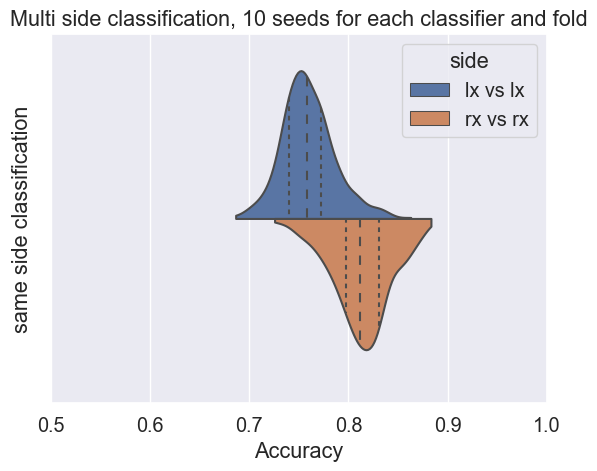

In [32]:
import matplotlib.pyplot as plt
from seaborn import violinplot

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile', cut=0)
plt.title("Multi side classification, 10 seeds for each classifier and fold")
ax.set_xlim(0.5, 1.0)
plt.show()

## LOSO

In [11]:
model_selected: str = "RandomForestClassifier"
metrics_selected: str = 'Accuracy'
n_seeds_to_test_classifiers: int = 30

### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [22]:
averaged_results_loso_lxlx, all_results_loso_lxlx = run_same_side_classifications(
    features_left,
    labels_left,
    groups_left,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
    n_jobs=-1,
    augment_data=True,
    augmentation_params={"augmentation_percent": 2., "augmentation_seed": 56}
)


Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:02<00:00, 10.78it/s]


In [24]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.6654            0.6654  0.6654   0.6341   
BernoulliNB                     0.6393            0.6393  0.6393   0.6044   
NuSVC                           0.6276            0.6276  0.6276   0.5936   
LGBMClassifier                  0.6133            0.6133  0.6133   0.5814   
NearestCentroid                 0.6120            0.6120  0.6120   0.5890   
ExtraTreesClassifier            0.6101            0.6101  0.6101   0.5779   
LabelPropagation                0.6068            0.6068  0.6068   0.5812   
XGBClassifier                   0.6055            0.6055  0.6055   0.5773   
LabelSpreading                  0.6016            0.6016  0.6016   0.5757   
RandomForestClassifier          0.5994            0.5994  0.5994   0.5670   
BaggingClassifier               0.5968            0.5968  0.5968   0.5718   
KNeighborsClassifier            0.5938            0.5938  0.5938   0.5609   
ExtraTreeClassifier             0.5833            0.5833  0.5833   0.5640   
AdaBoostClassifier              0.5781            0.5781  0.5781   0.5503   
GaussianNB                      0.5391            0.5391  0.5391   0.4151   
QuadraticDiscriminantAnalysis   0.5391            0.5391  0.5391   0.4117   
CalibratedClassifierCV          0.5286            0.5286  0.5286   0.4826   
RidgeClassifierCV               0.5273            0.5273  0.5273   0.4733   
LogisticRegression              0.5260            0.5260  0.5260   0.4724   
LinearSVC                       0.5226            0.5226  0.5226   0.4691   
RidgeClassifier                 0.5221            0.5221  0.5221   0.4688   
LinearDiscriminantAnalysis      0.5208            0.5208  0.5208   0.4672   
Perceptron                      0.5199            0.5199  0.5199   0.4643   
DecisionTreeClassifier          0.5162            0.5162  0.5162   0.4871   
SGDClassifier                   0.5094            0.5094  0.5094   0.4470   
PassiveAggressiveClassifier     0.5018            0.5018  0.5018   0.4305   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.1813         0.0231            0.0231   
BernoulliNB                       0.0057         0.0278            0.0278   
NuSVC                             0.2754         0.0219            0.0219   
LGBMClassifier                    0.0727         0.0204            0.0204   
NearestCentroid                   0.0059         0.0278            0.0278   
ExtraTreesClassifier              0.2307         0.0208            0.0208   
LabelPropagation                  0.1059         0.0192            0.0192   
XGBClassifier                     0.3838         0.0203            0.0203   
LabelSpreading                    0.2279         0.0194            0.0194   
RandomForestClassifier            0.4882         0.0190            0.0190   
BaggingClassifier                 0.1494         0.0185            0.0185   
KNeighborsClassifier              0.0077         0.0198            0.0198   
ExtraTreeClassifier               0.0067         0.0164            0.0164   
AdaBoostClassifier                0.1872         0.0210            0.0210   
GaussianNB                        0.0067         0.0060            0.0060   
QuadraticDiscriminantAnalysis     0.0058         0.0064            0.0064   
CalibratedClassifierCV            0.5976         0.0165            0.0165   
RidgeClassifierCV                 0.0067         0.0194            0.0194   
LogisticRegression                0.0102         0.0187            0.0187   
LinearSVC                 

### Test with different seeds (RX vs RX)

In [25]:
averaged_results_loso_rxrx, all_results_loso_rxrx = run_same_side_classifications(
    features_right, labels_right, groups_right, n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
    augment_data=True,
    augmentation_params={"augmentation_percent": 2., "augmentation_seed": 56}
)


Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:03<00:00,  9.60it/s]

100%|██████████| 29/29 [00:02<00:00, 11.39it/s]


In [26]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7474            0.7474  0.7474   0.7229   
NuSVC                           0.7448            0.7448  0.7448   0.7212   
LGBMClassifier                  0.7396            0.7396  0.7396   0.7209   
ExtraTreesClassifier            0.7375            0.7375  0.7375   0.7174   
XGBClassifier                   0.7357            0.7357  0.7357   0.7192   
GaussianNB                      0.7357            0.7357  0.7357   0.7080   
RandomForestClassifier          0.7308            0.7308  0.7308   0.7128   
KNeighborsClassifier            0.7240            0.7240  0.7240   0.7062   
BaggingClassifier               0.7140            0.7140  0.7140   0.6991   
LabelPropagation                0.7135            0.7135  0.7135   0.6940   
LabelSpreading                  0.7135            0.7135  0.7135   0.6929   
NearestCentroid                 0.7083            0.7083  0.7083   0.6931   
BernoulliNB                     0.7057            0.7057  0.7057   0.6799   
QuadraticDiscriminantAnalysis   0.7044            0.7044  0.7044   0.6878   
DecisionTreeClassifier          0.6812            0.6812  0.6812   0.6615   
ExtraTreeClassifier             0.6737            0.6737  0.6737   0.6598   
AdaBoostClassifier              0.6419            0.6419  0.6419   0.6127   
RidgeClassifier                 0.5977            0.5977  0.5977   0.5637   
RidgeClassifierCV               0.5977            0.5977  0.5977   0.5637   
LinearDiscriminantAnalysis      0.5964            0.5964  0.5964   0.5627   
LinearSVC                       0.5956            0.5956  0.5956   0.5624   
LogisticRegression              0.5951            0.5951  0.5951   0.5606   
CalibratedClassifierCV          0.5781            0.5781  0.5781   0.5433   
SGDClassifier                   0.5679            0.5679  0.5679   0.5154   
PassiveAggressiveClassifier     0.5296            0.5296  0.5296   0.4659   
Perceptron                      0.5263            0.5263  0.5263   0.4710   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.1411         0.0182            0.0182   
NuSVC                             0.1859         0.0183            0.0183   
LGBMClassifier                    0.0733         0.0173            0.0173   
ExtraTreesClassifier              0.2131         0.0163            0.0163   
XGBClassifier                     0.3804         0.0169            0.0169   
GaussianNB                        0.0070         0.0176            0.0176   
RandomForestClassifier            0.4614         0.0175            0.0175   
KNeighborsClassifier              0.0080         0.0160            0.0160   
BaggingClassifier                 0.1437         0.0180            0.0180   
LabelPropagation                  0.1072         0.0151            0.0151   
LabelSpreading                    0.2304         0.0154            0.0154   
NearestCentroid                   0.0056         0.0271            0.0271   
BernoulliNB                       0.0059         0.0268            0.0268   
QuadraticDiscriminantAnalysis     0.0056         0.0172            0.0172   
DecisionTreeClassifier            0.0268         0.0163            0.0163   
ExtraTreeClassifier               0.0066         0.0155            0.0155   
AdaBoostClassifier                0.1899         0.0155            0.0155   
RidgeClassifier                   0.0063         0.0253            0.0253   
RidgeClassifierCV                 0.0067         0.0253            0.0253   
LinearDiscriminantAnalysis

### Visualizing results (same side)

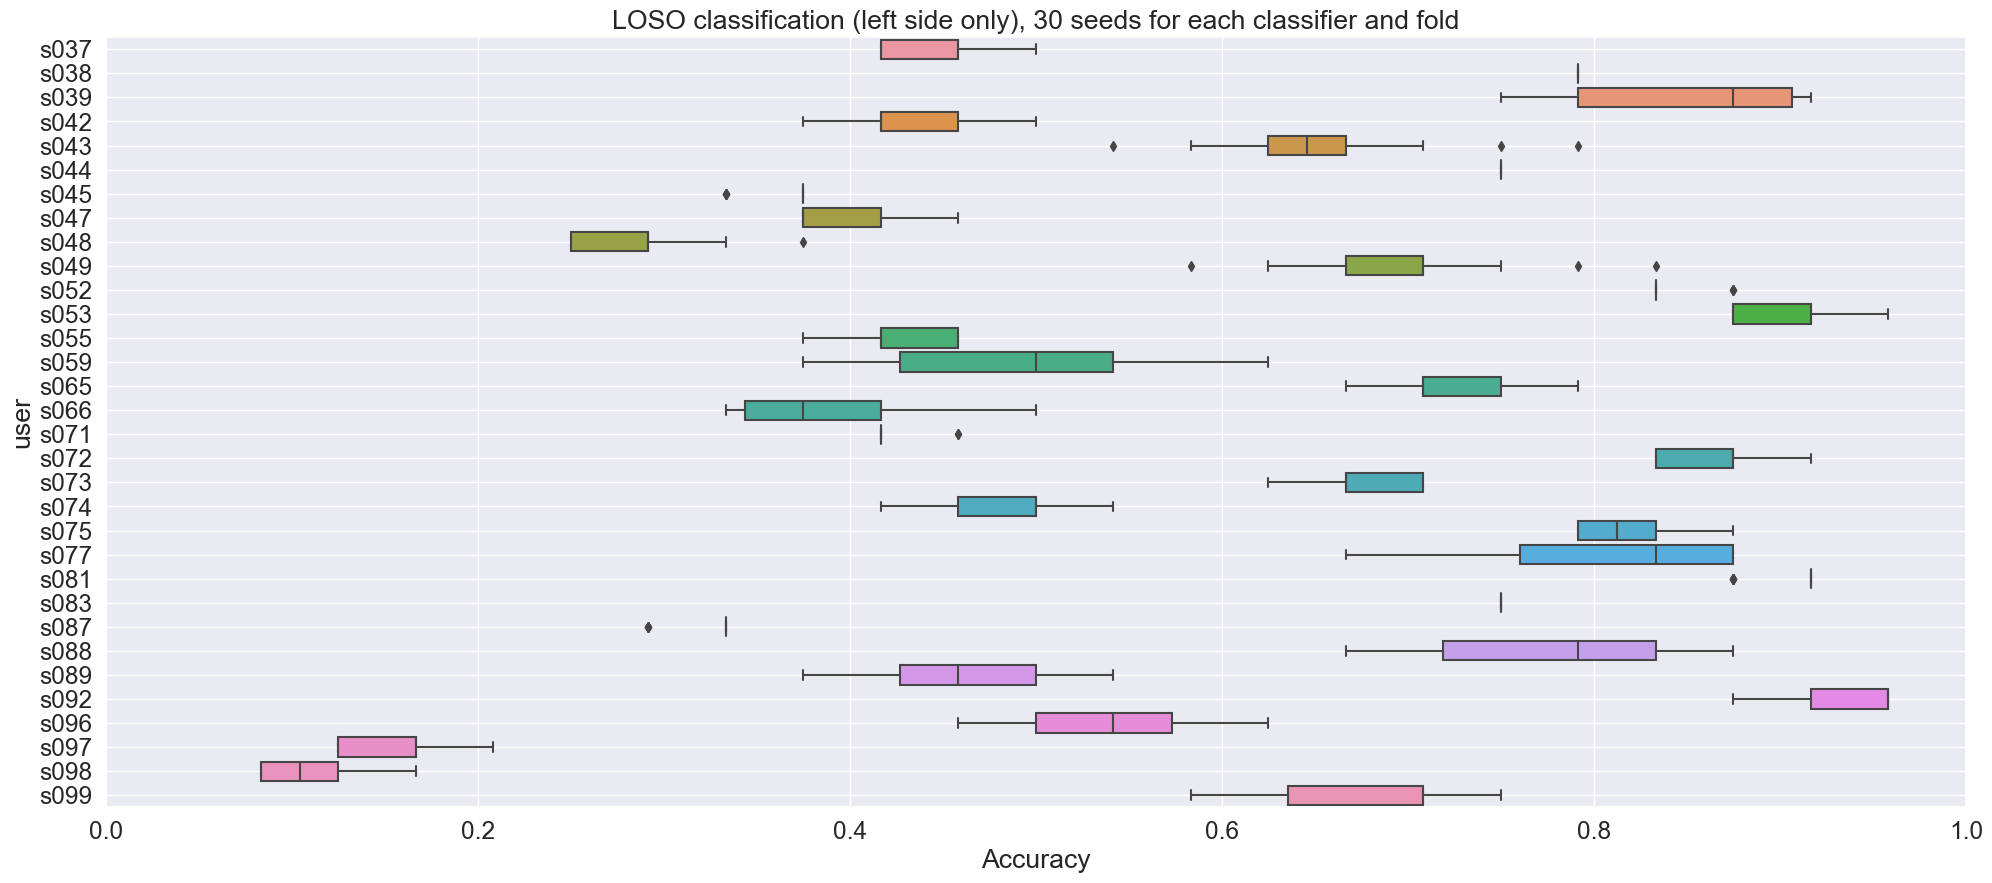

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 10))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user")
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.title(f"LOSO classification (left side only), {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0)
plt.show()


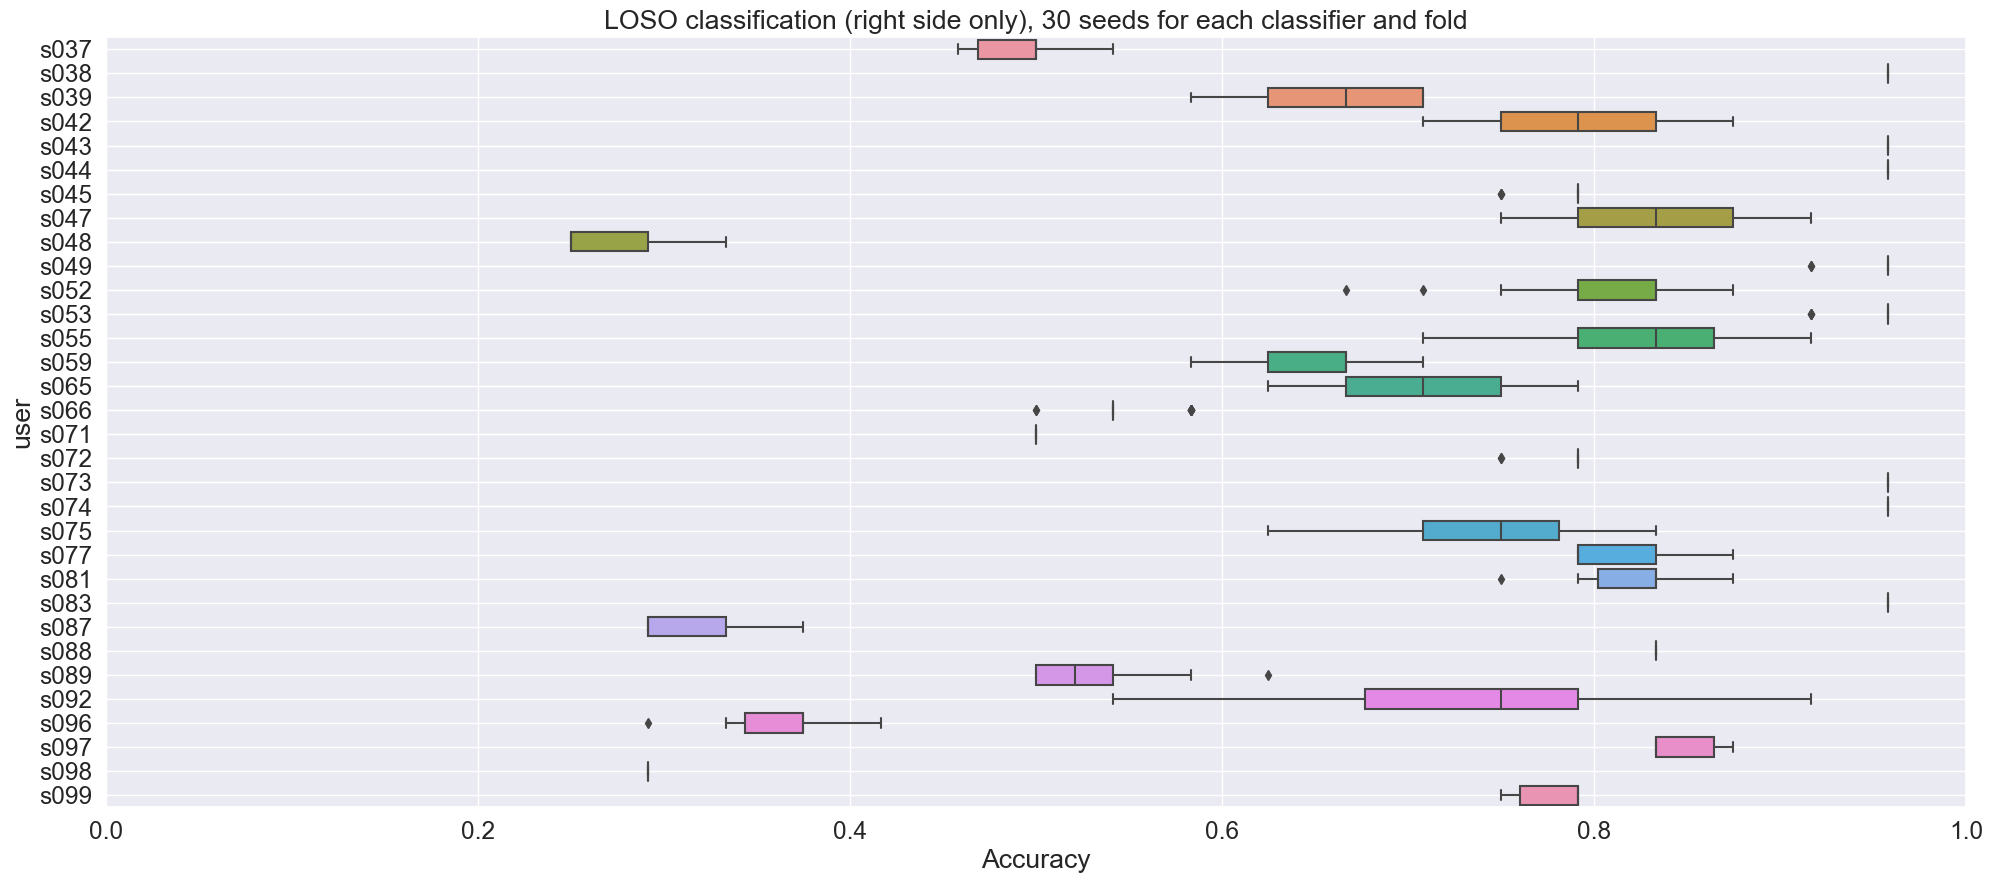

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns


selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

plt.figure(figsize=(24, 10))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user")
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.title(f"LOSO classification (right side only), {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0)
plt.show()


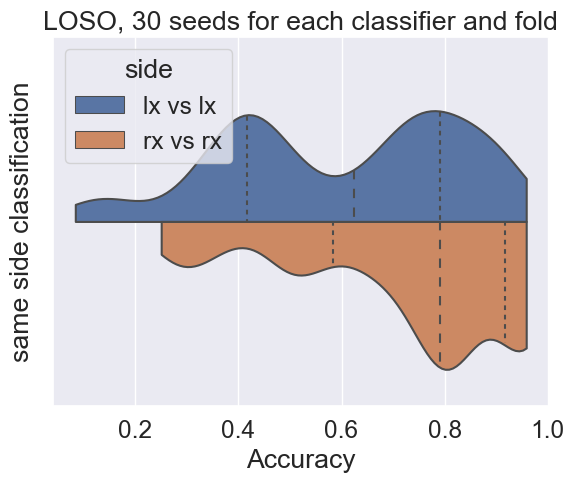

In [29]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile', cut=0)
plt.title(f"LOSO, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
# ax.set_xlim(0.5, 1.0)
plt.show()

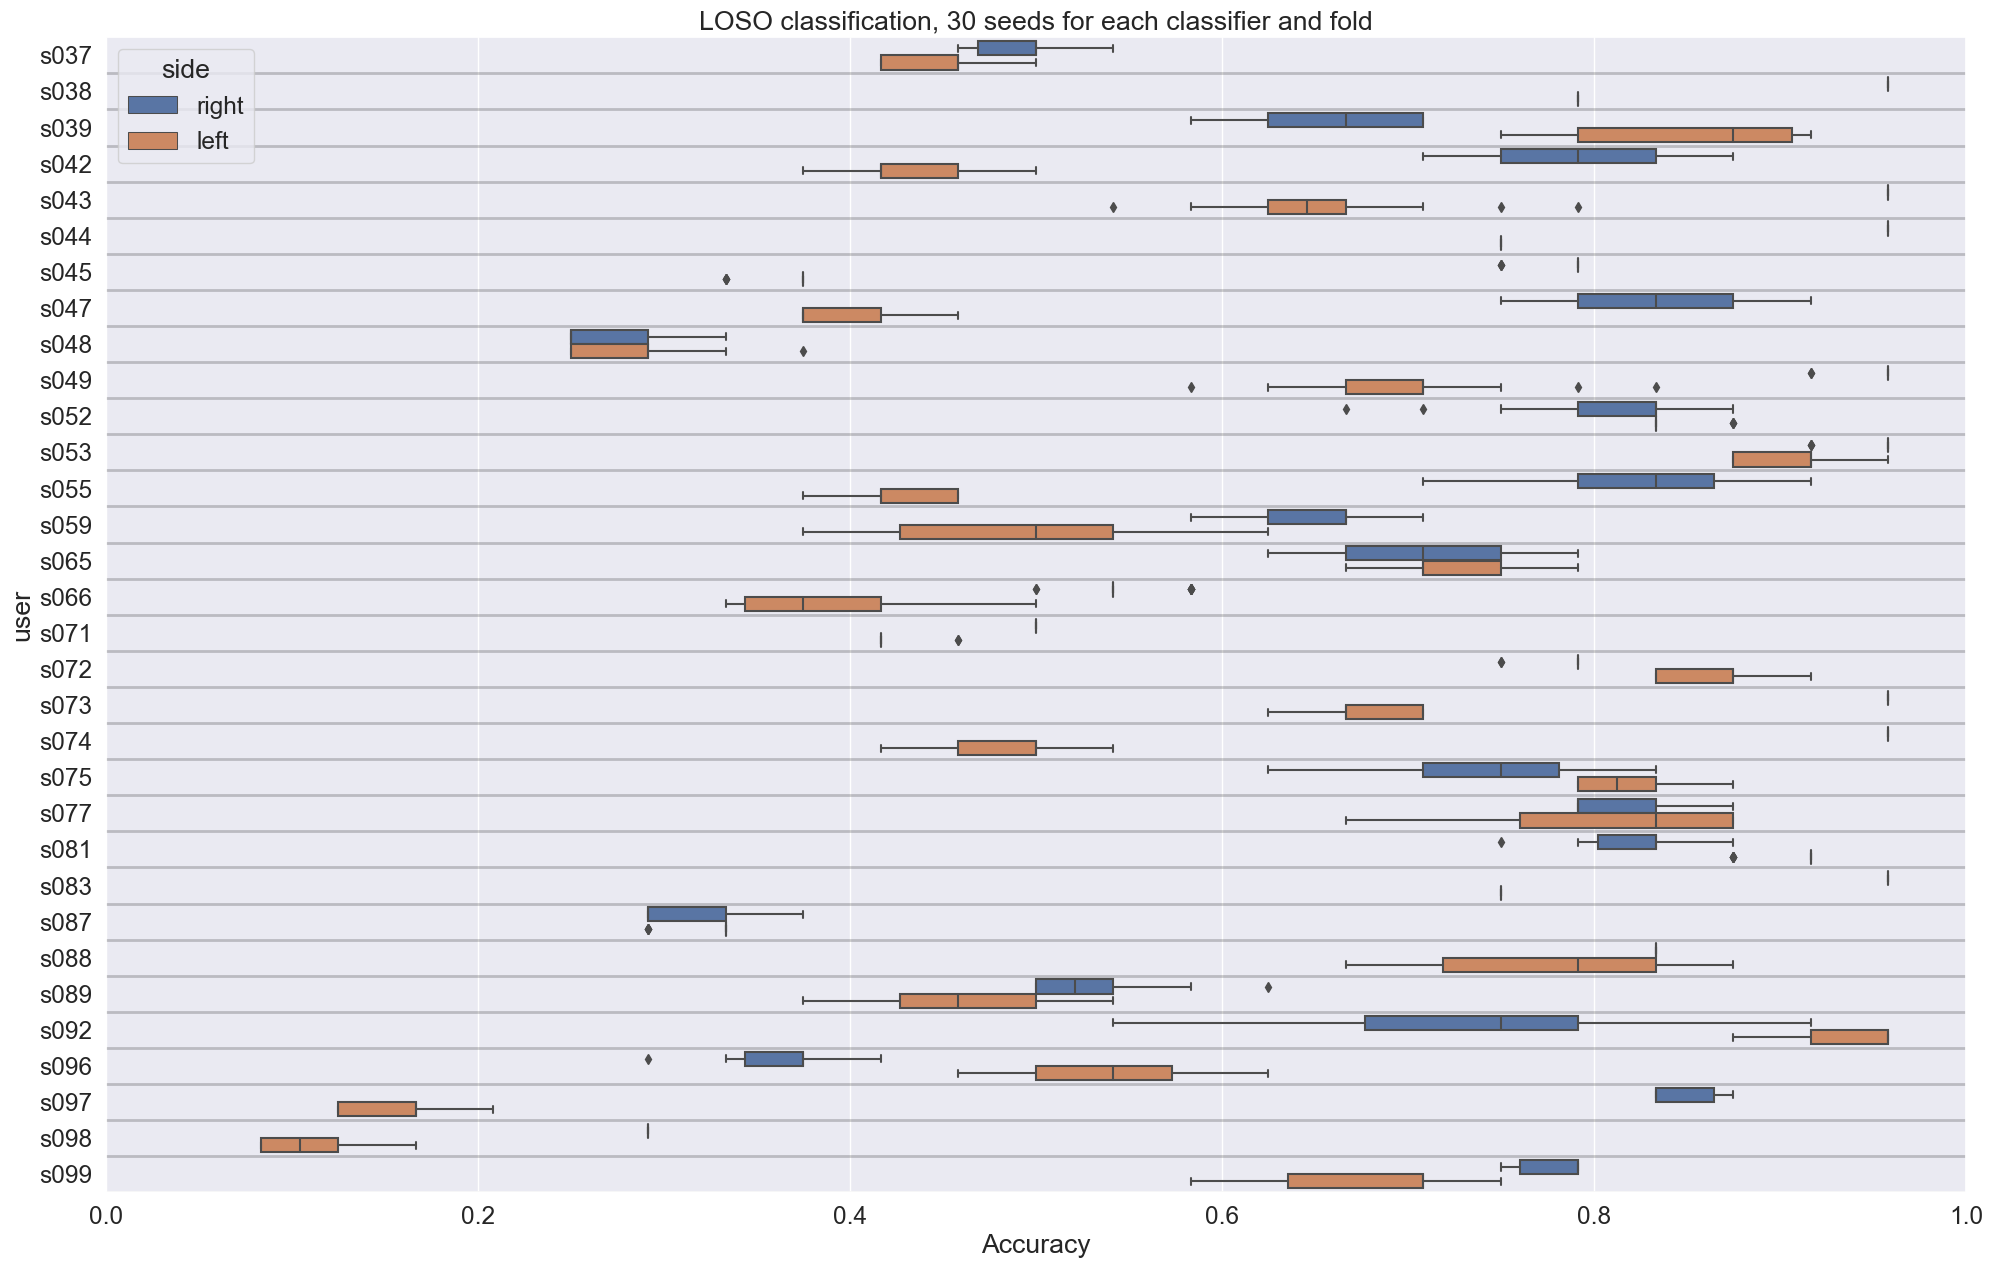

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 15))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx, *selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


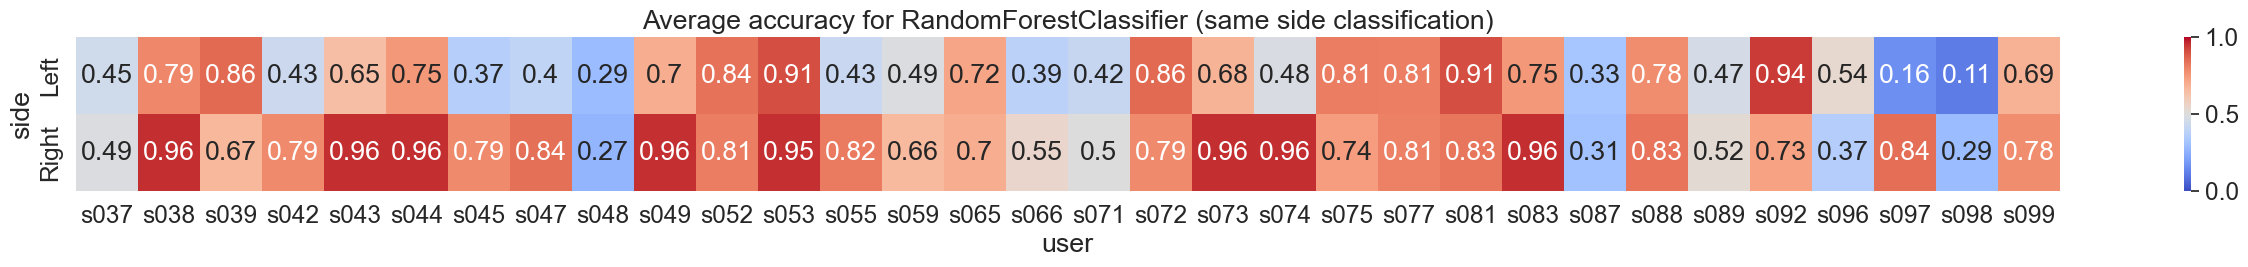

In [31]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (same side classification)")
plt.show()

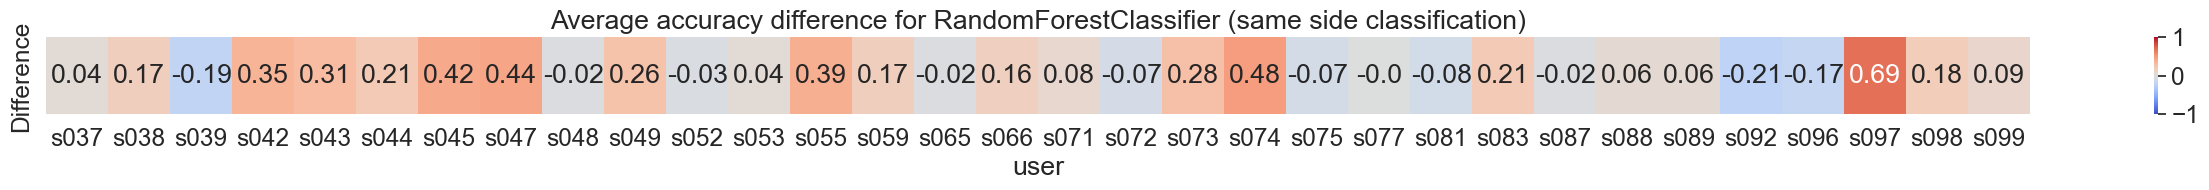

In [21]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
data_to_plot3 = data_to_plot2.iloc[1,:] - data_to_plot2.iloc[0,:]
data_to_plot3 = DataFrame(data_to_plot3, columns=['Difference']).T

plt.figure(figsize=(len(data_to_plot3.columns),1))
ax = sns.heatmap(data_to_plot3, 
            yticklabels=['Difference'],
            cmap='coolwarm', 
            annot=data_to_plot3.round(decimals=2).values,
            vmin=-1, vmax=1,
            center=0,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy difference for {model_selected} (same side classification)")
plt.show()

Here is it noted that the distribution of labels across each individual is the same as the total, since the duration of the experiment was them same. It is also noted that a per-user undersampling is performed.

In [25]:
# from pandas import Series 

# selected_user: str = "s077"
# left_data_mask: ndarray = groups_left == selected_user
# current_labels_left = labels_left[left_data_mask]
# right_data_mask: ndarray = groups_right == selected_user
# current_labels_right = labels_right[right_data_mask]

# counts = {
#     "left": Series(current_labels_left).value_counts(),
#     "right": Series(current_labels_right).value_counts(),
# }
# counts = DataFrame(counts).unstack().reset_index()
# counts.columns = ["side", "label", "count"]
# counts["label"] = counts["label"].map({0: "relaxation", 1: "cognitive load"})
# plot_binary_labels(
#     counts=counts,
#     title=f"Distribution of labels, USILaughs dataset, user {selected_user}",
#     dataset_name=f"usilaughs_{selected_user}",
#     output_folder="../visualizations/"
# )


### Test with different seeds (LX vs RX)

In [12]:
averaged_results_loso_lxrx, all_results_loso_lxrx = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
    n_jobs=-1,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.54it/s]

100%|██████████| 29/29 [00:00<00:00, 42.64it/s]


In [13]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_lxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
KNeighborsClassifier            0.7383            0.7383  0.7383   0.7257   
SVC                             0.7370            0.7370  0.7370   0.7088   
ExtraTreesClassifier            0.7197            0.7197  0.7197   0.7072   
CalibratedClassifierCV          0.7161            0.7161  0.7161   0.6958   
NuSVC                           0.7122            0.7122  0.7122   0.6860   
RandomForestClassifier          0.7118            0.7118  0.7118   0.6952   
LabelSpreading                  0.7109            0.7109  0.7109   0.7003   
LabelPropagation                0.7083            0.7083  0.7083   0.6984   
AdaBoostClassifier              0.7036            0.7036  0.7036   0.6867   
LinearSVC                       0.7030            0.7030  0.7030   0.6854   
RidgeClassifier                 0.7005            0.7005  0.7005   0.6805   
LogisticRegression              0.7005            0.7005  0.7005   0.6841   
RidgeClassifierCV               0.6992            0.6992  0.6992   0.6800   
LinearDiscriminantAnalysis      0.6992            0.6992  0.6992   0.6804   
XGBClassifier                   0.6875            0.6875  0.6875   0.6771   
NearestCentroid                 0.6810            0.6810  0.6810   0.6605   
BaggingClassifier               0.6740            0.6740  0.6740   0.6614   
BernoulliNB                     0.6693            0.6693  0.6693   0.6527   
LGBMClassifier                  0.6654            0.6654  0.6654   0.6514   
ExtraTreeClassifier             0.6365            0.6365  0.6365   0.6241   
DecisionTreeClassifier          0.6199            0.6199  0.6199   0.6091   
SGDClassifier                   0.5882            0.5882  0.5882   0.5479   
Perceptron                      0.5610            0.5610  0.5610   0.5181   
PassiveAggressiveClassifier     0.5540            0.5540  0.5540   0.5033   
GaussianNB                      0.5339            0.5339  0.5339   0.4169   
QuadraticDiscriminantAnalysis   0.5013            0.5013  0.5013   0.3975   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
KNeighborsClassifier              0.0050         0.0151            0.0151   
SVC                               0.0159         0.0175            0.0175   
ExtraTreesClassifier              0.0901         0.0155            0.0155   
CalibratedClassifierCV            0.1501         0.0251            0.0251   
NuSVC                             0.0228         0.0170            0.0170   
RandomForestClassifier            0.1387         0.0160            0.0160   
LabelSpreading                    0.0130         0.0142            0.0142   
LabelPropagation                  0.0094         0.0135            0.0135   
AdaBoostClassifier                0.0664         0.0150            0.0150   
LinearSVC                         0.0398         0.0263            0.0263   
RidgeClassifier                   0.0050         0.0267            0.0267   
LogisticRegression                0.0079         0.0266            0.0266   
RidgeClassifierCV                 0.0053         0.0271            0.0271   
LinearDiscriminantAnalysis        0.0051         0.0271            0.0271   
XGBClassifier                     0.0990         0.0162            0.0162   
NearestCentroid                   0.0050         0.0270            0.0270   
BaggingClassifier                 0.0343         0.0155            0.0155   
BernoulliNB                       0.0045         0.0226            0.0226   
LGBMClassifier                    0.0457         0.0170            0.0170   
ExtraTreeClassifier       

### Test with different seeds (RX vs LX)

In [14]:
averaged_results_loso_rxlx, all_results_loso_rxlx = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 42.71it/s]

100%|██████████| 29/29 [00:00<00:00, 44.97it/s]


In [15]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
KNeighborsClassifier            0.6953            0.6953  0.6953   0.6776   
LabelSpreading                  0.6836            0.6836  0.6836   0.6696   
LabelPropagation                0.6823            0.6823  0.6823   0.6687   
ExtraTreesClassifier            0.6781            0.6781  0.6781   0.6569   
RandomForestClassifier          0.6766            0.6766  0.6766   0.6545   
LGBMClassifier                  0.6732            0.6732  0.6732   0.6522   
BaggingClassifier               0.6635            0.6635  0.6635   0.6448   
NuSVC                           0.6628            0.6628  0.6628   0.6329   
SVC                             0.6615            0.6615  0.6615   0.6312   
XGBClassifier                   0.6536            0.6536  0.6536   0.6322   
AdaBoostClassifier              0.6484            0.6484  0.6484   0.6269   
GaussianNB                      0.6419            0.6419  0.6419   0.6114   
ExtraTreeClassifier             0.6366            0.6366  0.6366   0.6215   
QuadraticDiscriminantAnalysis   0.6302            0.6302  0.6302   0.5901   
NearestCentroid                 0.6289            0.6289  0.6289   0.6022   
DecisionTreeClassifier          0.6279            0.6279  0.6279   0.6113   
RidgeClassifier                 0.6276            0.6276  0.6276   0.6086   
LinearDiscriminantAnalysis      0.6276            0.6276  0.6276   0.6097   
LinearSVC                       0.6270            0.6270  0.6270   0.6103   
CalibratedClassifierCV          0.6250            0.6250  0.6250   0.6016   
LogisticRegression              0.6224            0.6224  0.6224   0.6044   
RidgeClassifierCV               0.6224            0.6224  0.6224   0.6019   
BernoulliNB                     0.6172            0.6172  0.6172   0.5931   
SGDClassifier                   0.5967            0.5967  0.5967   0.5668   
PassiveAggressiveClassifier     0.5743            0.5743  0.5743   0.5328   
Perceptron                      0.5645            0.5645  0.5645   0.5331   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
KNeighborsClassifier              0.0042         0.0181            0.0181   
LabelSpreading                    0.0114         0.0158            0.0158   
LabelPropagation                  0.0082         0.0160            0.0160   
ExtraTreesClassifier              0.0729         0.0213            0.0213   
RandomForestClassifier            0.1139         0.0219            0.0219   
LGBMClassifier                    0.0417         0.0205            0.0205   
BaggingClassifier                 0.0290         0.0208            0.0208   
NuSVC                             0.0137         0.0224            0.0224   
SVC                               0.0115         0.0234            0.0234   
XGBClassifier                     0.0829         0.0205            0.0205   
AdaBoostClassifier                0.0570         0.0233            0.0233   
GaussianNB                        0.0039         0.0257            0.0257   
ExtraTreeClassifier               0.0038         0.0180            0.0180   
QuadraticDiscriminantAnalysis     0.0036         0.0171            0.0171   
NearestCentroid                   0.0038         0.0290            0.0290   
DecisionTreeClassifier            0.0070         0.0204            0.0204   
RidgeClassifier                   0.0042         0.0279            0.0279   
LinearDiscriminantAnalysis        0.0042         0.0271            0.0271   
LinearSVC                         0.0352         0.0277            0.0277   
CalibratedClassifierCV    

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.

### Visualizing results (different side)

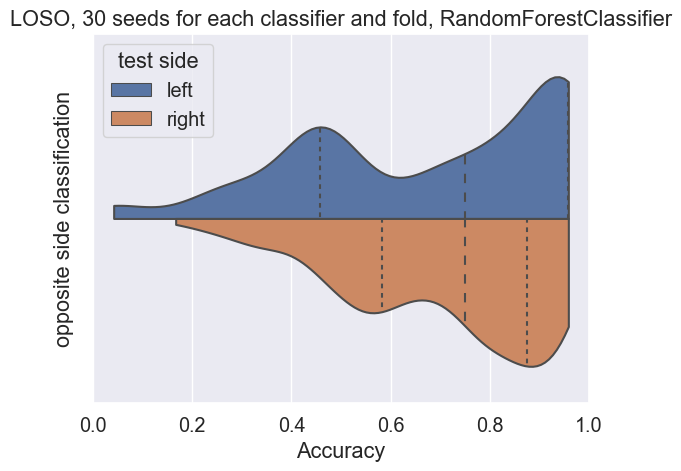

In [18]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right")
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left")
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

extra_col_name: str = 'opposite side classification'
data_to_plot = DataFrame([*selected_results_rxlx, *selected_results_lxrx], columns=[metrics_selected, "test side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='test side', split=True, inner='quartile', cut=0)
plt.title(f"LOSO, {n_seeds_to_test_classifiers} seeds for each classifier and fold, {model_selected}")
ax.set_xlim(0., 1.0)
plt.show()

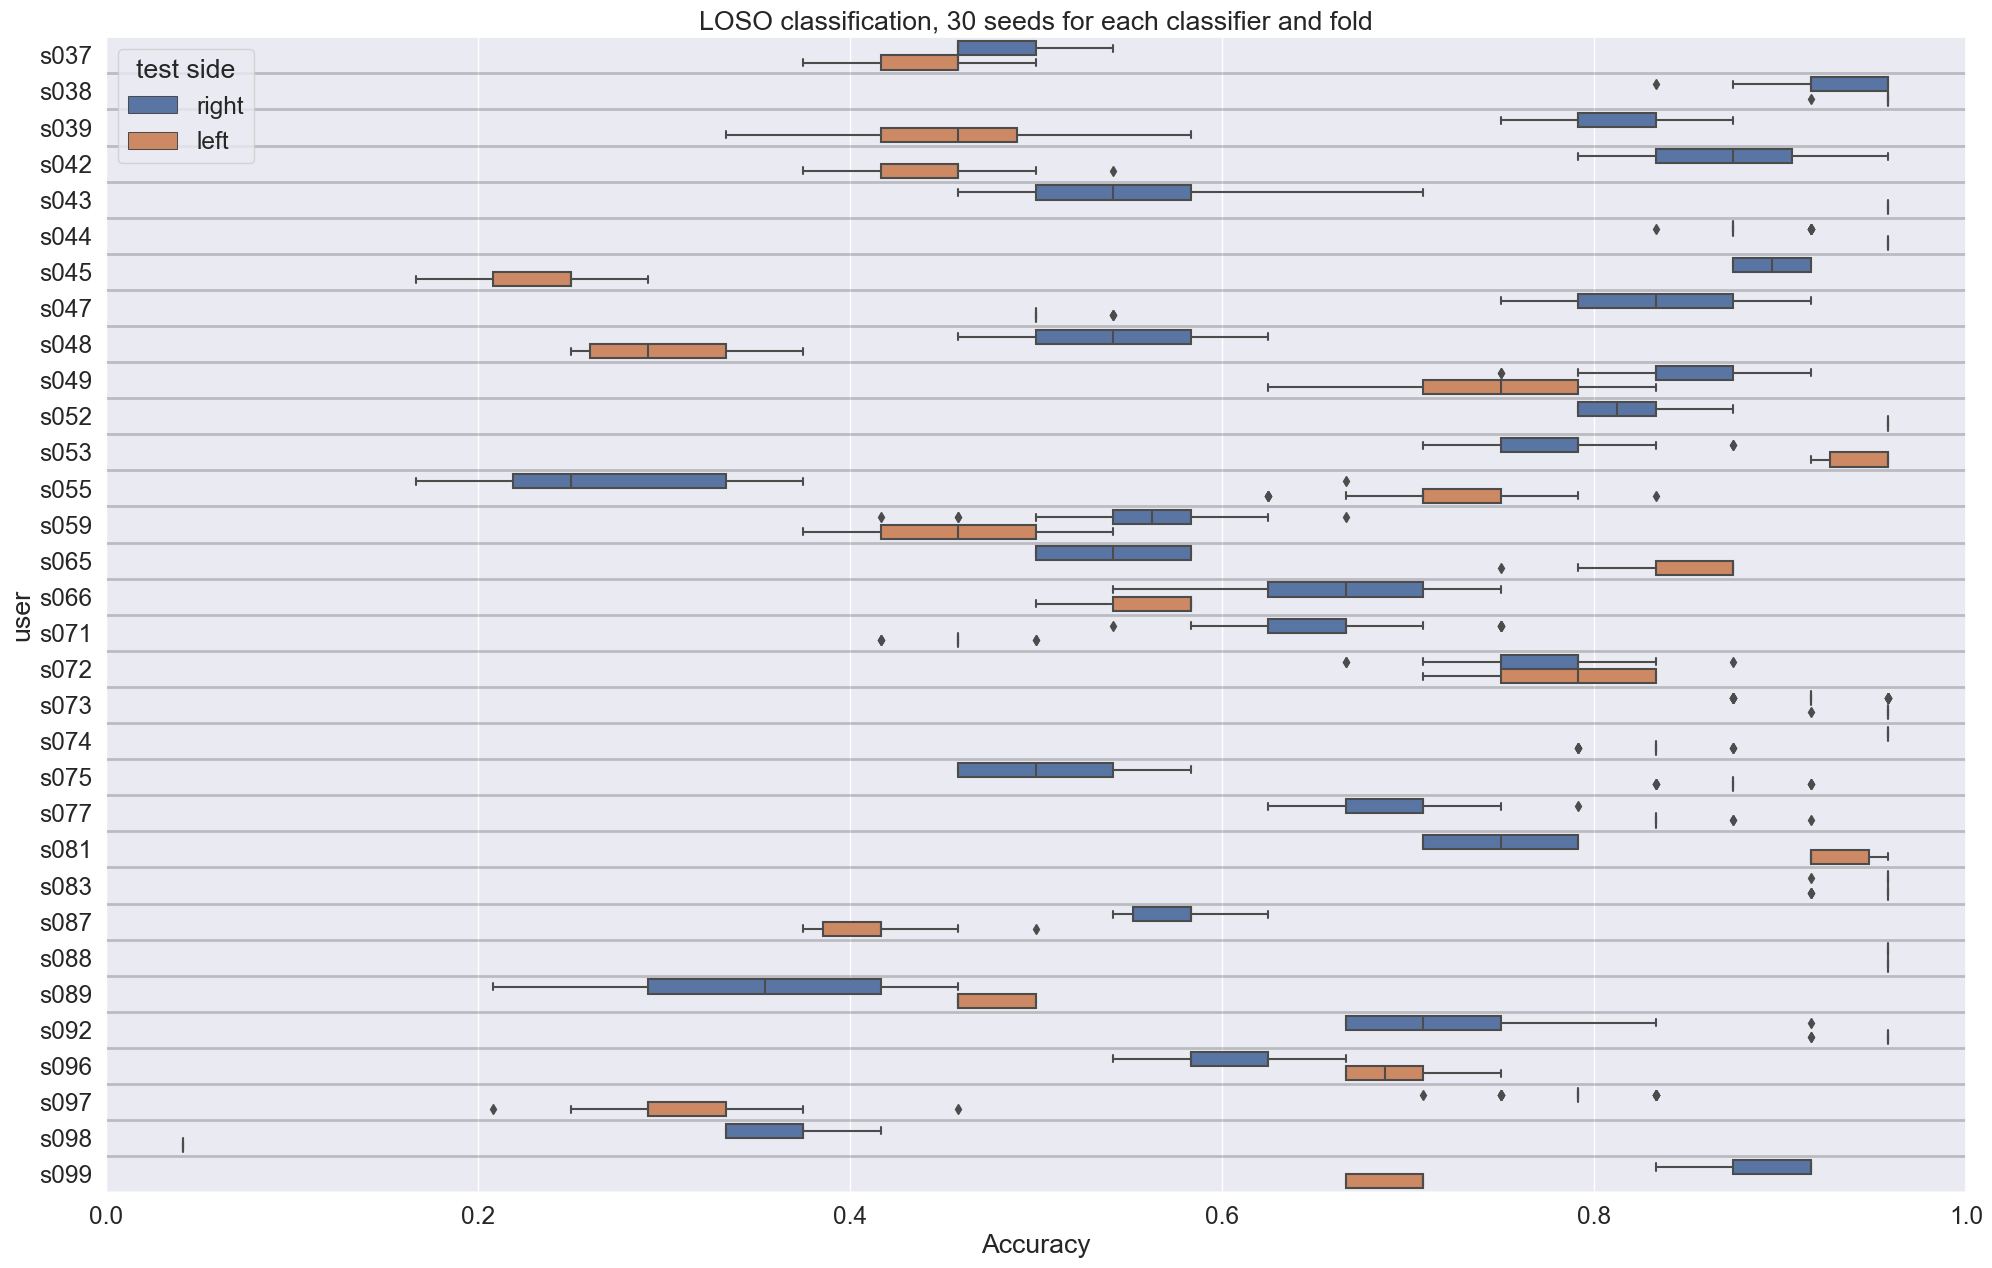

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 15))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_lxrx, *selected_results_rxlx], columns=[metrics_selected, "test side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='test side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


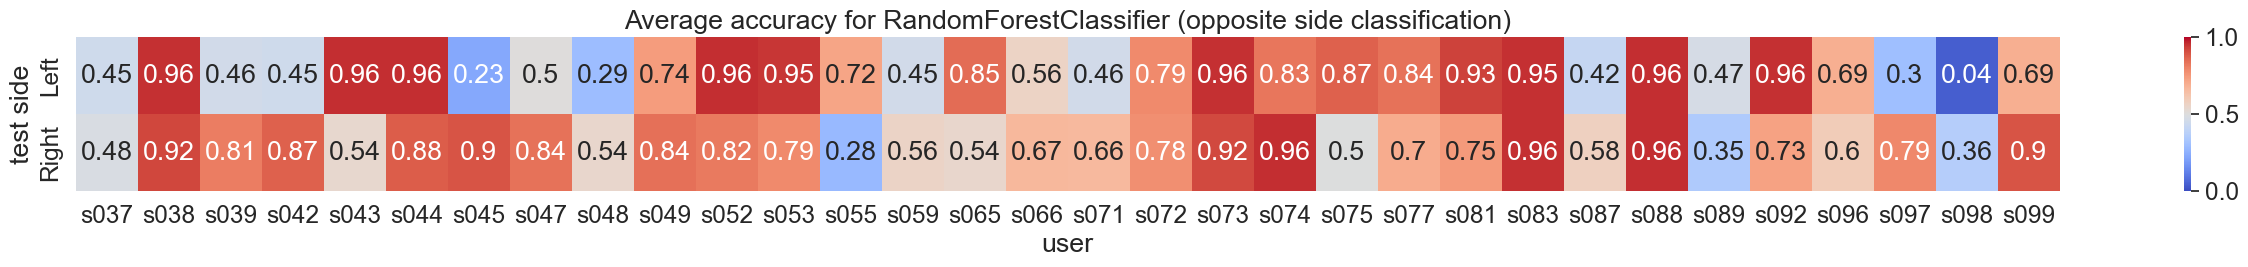

In [23]:
data_to_plot2 = data_to_plot.groupby(['user', 'test side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (opposite side classification)")
plt.show()

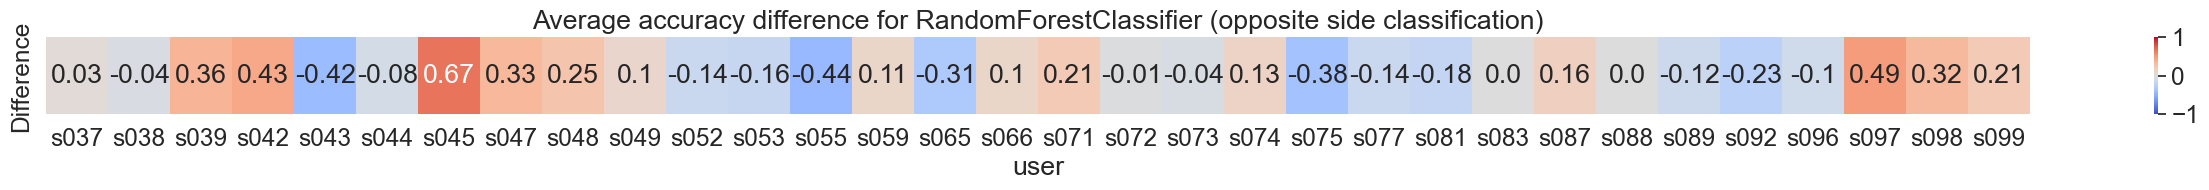

In [24]:
data_to_plot2 = data_to_plot.groupby(['user', 'test side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
data_to_plot3 = data_to_plot2.iloc[1,:] - data_to_plot2.iloc[0,:]
data_to_plot3 = DataFrame(data_to_plot3, columns=['Difference']).T

plt.figure(figsize=(len(data_to_plot3.columns),1))
ax = sns.heatmap(data_to_plot3, 
            yticklabels=['Difference'],
            cmap='coolwarm', 
            annot=data_to_plot3.round(decimals=2).values,
            vmin=-1, vmax=1,
            center=0,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy difference for {model_selected} (opposite side classification)")
plt.show()

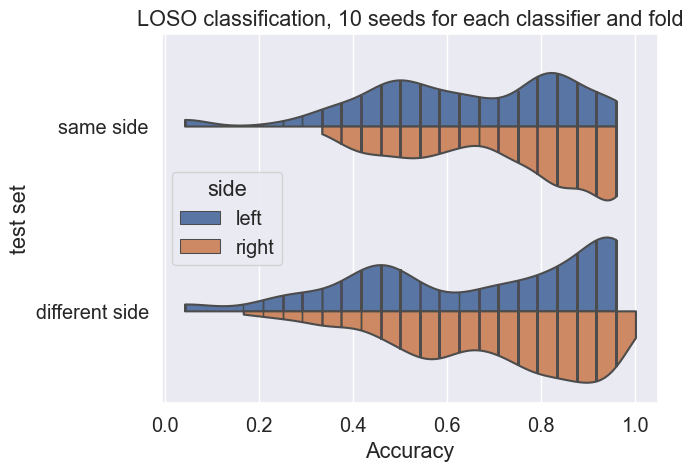

In [22]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", "same side")
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", "same side")
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", "different side")
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", "different side")
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx, *selected_results_lxrx, *selected_results_rxlx], columns=[metrics_selected, "side", "test set"])
ax = violinplot(data_to_plot, x=metrics_selected, y="test set", hue='side', split=True, inner='stick', cut=0)
plt.title("LOSO classification, 10 seeds for each classifier and fold")
# ax.set_xlim(0.5, 1.0)
plt.show()